<a href="https://colab.research.google.com/github/isaacchunn/SC1015_MiniPrj_Airbnb/blob/main/AirbnbAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Airbnb Prediction in Python (change this later to some title)

Dataset from Airbnb : **"Singapore, 29 December 2022"**  
Source: http://insideairbnb.com/get-the-data/

---

### Essential Libraries

Import essential libraries such as numpy, pandas, matplotlib and seaborn.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [82]:
# Isaac Chun Jun Heng U221389B
# J'sen Ong Jia Xuan
# TM.

In [83]:
#Basic libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt #We only need pyplot
sb.set() #Set the default Seaborn style for graphics

### Additional Dependencies

In [84]:
!pip install geopandas

### Additional Libraries

In [85]:
from IPython import display
import folium
import geopandas


### General Utility Functions

In [86]:
def countOutliers (df):
    #Get the q1 and q3 datas to find out the 25% and 75% range, then calculate inter quartile range and then find out whiskers.
    #Then count how many points lie outside of this range.
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    #Interquartile
    iqr = q3 - q1
    #Calculate whiskers
    leftWhisker = q1 - (1.5 * iqr)
    rightWhisker = q3 + (1.5 * iqr)
    outliers = 0;
    #Loop through data now
    for data in df:
        if(data < leftWhisker or data > rightWhisker):
            outliers+=1

    return outliers

In [87]:
def removeOutliers(df, colName):
  q1 = df[colName].quantile(0.25)
  q3 = df[colName].quantile(0.75)
  iqr = q3-q1
  low = q1 - 1.5 * iqr
  high = q3 + 1.5 * iqr
  result = df.loc[(df[colName] >= low) & (df[colName] <= high)]
  return result

#What is Airbnb?

Airbnb, Inc. is an American San Francisco-based company operating an online marketplace for short-term homestays and experiences. The company acts as a broker and charges a commission from each booking. The company was founded in 2008 by Brian Chesky, Nathan Blecharczyk, and Joe Gebbia.




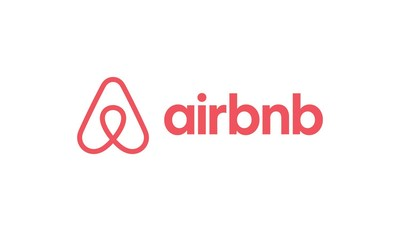

In [88]:
display.Image("https://mma.prnewswire.com/media/1121685/Airbnb_Logo.jpg")

---

### Import the Dataset

In [89]:
#Import the dataset from github so its accessible (token first, when unprivate repo can remove token)
#dataURL = "listings.csv"
#airDF = pd.read_csv(dataURL)
airDF = pd.read_csv("listings.csv") #Uncomment if doing local
airDF.head()

id                          listing_url     scrape_id last_scraped  \
0   71609.0   https://www.airbnb.com/rooms/71609  2.022120e+13   12/29/2022   
1   71896.0   https://www.airbnb.com/rooms/71896  2.022120e+13   12/29/2022   
2   71903.0   https://www.airbnb.com/rooms/71903  2.022120e+13   12/29/2022   
3  275343.0  https://www.airbnb.com/rooms/275343  2.022120e+13   12/29/2022   
4  275344.0  https://www.airbnb.com/rooms/275344  2.022120e+13   12/29/2022   

        source                                       name  \
0  city scrape        Ensuite Room (Room 1 & 2) near EXPO   
1  city scrape            B&B  Room 1 near Airport & EXPO   
2  city scrape                 Room 2-near Airport & EXPO   
3  city scrape  Amazing Room with window 10min to Redhill   
4  city scrape          15 mins to Outram MRT Single Room   

                                         description  \
0  For 3 rooms.Book room 1&2 and room 4<br /><br ...   
1  <b>The space</b><br />Vocational Stay Deluxe B...   
2  Like your own home, 24hrs access.<br /><br /><...   
3  Awesome location and host <br />Room near INSE...   
4  Lovely home for the special guest !<br /><br /...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2  Quiet and view of the playground with exercise...   
3                                                NaN   
4       Bus stop <br />Food center <br />Supermarket   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/24453191/3580...   367042  ...   
1  https://a0.muscache.com/pictures/2440674/ac4f4...   367042  ...   
2  https://a0.muscache.com/pictures/568743/7bc623...   367042  ...   
3  https://a0.muscache.com/pictures/miso/Hosting-...  1439258  ...   
4  https://a0.muscache.com/pictures/miso/Hosting-...  1439258  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.78                   4.26                4.32   
1                        4.43                   4.17                4.04   
2                        4.64                   4.50                4.36   
3                        4.42                   4.53                4.63   
4                        4.54                   4.62                4.46   

  license instant_bookable calculated_host_listings_count  \
0     NaN                f                              6   
1     NaN                t                              6   
2     NaN                f                              6   
3   S0399                f                             46   
4   S0399                f                             46   

  calculated_host_listings_count_entire_homes  \
0                                           0   
1                                           0   
2                                           0   
3                                           2   
4                                           2   

  calculated_host_listings_count_private_rooms  \
0                                            6   
1                                            6   
2                                            6   
3                                           44   
4                                           44   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.15  
1                                           0              0.17  
2                                           0              0.33  
3                                           0              0.19  
4                                           0              0.11  

[5 rows x 75 columns]

# Clean first, will put into another document called EDA to explain why we drop.

In [90]:
airDF.drop_duplicates(inplace=True)

In [91]:
airDF.shape

(3035, 75)

Test Map Visualization

In [92]:
#Plot all first
lat_mean = airDF["latitude"].mean()
long_mean = airDF["longitude"].mean()
area_lat_long = pd.concat([airDF["latitude"],airDF["longitude"]], axis = 1)
area_lat_long = area_lat_long.values.tolist()


In [93]:
#Create the map
map = folium.Map(
    #Center the map here at location
    location = [lat_mean, long_mean], zoom_start = 12
)

In [94]:
geo = pd.read_csv("geodata.csv")
geo = geo.sort_values(by =["name"])
geo.reset_index(drop = True)
geo.head(n=5)

name  latitude   longitude
0    ANG MO KIO  1.369115  103.845434
1         BEDOK  1.323604  103.927341
2        BISHAN  1.352585  103.835212
31     BOON LAY  1.314289  103.708969
3   BUKIT BATOK  1.359029  103.763680

In [95]:
import random
#implementing combined coords into df
r = []
for i,n in enumerate(geo['name']):
    a = random.randint(0, 100)
    r.append(a)
geo['testprice'] = r
geo.head(5)

name  latitude   longitude  testprice
0    ANG MO KIO  1.369115  103.845434         70
1         BEDOK  1.323604  103.927341         96
2        BISHAN  1.352585  103.835212         15
31     BOON LAY  1.314289  103.708969         83
3   BUKIT BATOK  1.359029  103.763680         43

In [96]:
geojson = geopandas.read_file("sg.geojson")
geojson = geojson[['name','geometry']]
geojson.head(n=5)

name                                           geometry
0         BISHAN  POLYGON ((103.84924 1.36275, 103.84936 1.36268...
1    BUKIT BATOK  POLYGON ((103.76408 1.37001, 103.76444 1.36947...
2    BUKIT MERAH  POLYGON ((103.81740 1.29433, 103.81743 1.29431...
3  BUKIT PANJANG  POLYGON ((103.77445 1.39029, 103.77499 1.38607...
4    BUKIT TIMAH  POLYGON ((103.79766 1.34813, 103.79806 1.34779...

In [97]:
df_final = geojson.merge(geo, left_on = "name", right_on = "name", how = "outer")
df_final = df_final[~df_final['geometry'].isna()]
df_final

name  \
0                    BISHAN   
1               BUKIT BATOK   
2               BUKIT MERAH   
3             BUKIT PANJANG   
4               BUKIT TIMAH   
5   CENTRAL WATER CATCHMENT   
6                    CHANGI   
7                CHANGI BAY   
8             CHOA CHU KANG   
9                  CLEMENTI   
10                  GEYLANG   
11                   NOVENA   
12                PASIR RIS   
13               PAYA LEBAR   
14                  SELETAR   
15                SEMBAWANG   
16                    BEDOK   
17                 BOON LAY   
18                 SENGKANG   
19                SERANGOON   
20               ANG MO KIO   
21                   TENGAH   
22                TOA PAYOH   
23  WESTERN WATER CATCHMENT   
24                   YISHUN   
25            DOWNTOWN CORE   
26              MARINA EAST   
27                   NEWTON   
28                  ORCHARD   
29                WOODLANDS   
30             MARINA SOUTH   
31                   MUSEUM   
32                  HOUGANG   
33              JURONG EAST   
34             LIM CHU KANG   
35                   MANDAI   
36            MARINE PARADE   
37    NORTH-EASTERN ISLANDS   
38                  PIONEER   
39                  PUNGGOL   
40               QUEENSTOWN   
41         SOUTHERN ISLANDS   
42                     TUAS   
43              JURONG WEST   
44                  KALLANG   
45                  SIMPANG   
46             SUNGEI KADUT   
47                 TAMPINES   
48          WESTERN ISLANDS   
49                  TANGLIN   
50                   OUTRAM   
51             RIVER VALLEY   
52                   ROCHOR   
53          SINGAPORE RIVER   
54             STRAITS VIEW   

                                             geometry  latitude   longitude  \
0   POLYGON ((103.84924 1.36275, 103.84936 1.36268...  1.352585  103.835212   
1   POLYGON ((103.76408 1.37001, 103.76444 1.36947...  1.359029  103.763680   
2   POLYGON ((103.81740 1.29433, 103.81743 1.29431...  1.281905  103.823918   
3   POLYGON ((103.77445 1.39029, 103.77499 1.38607...  1.377414  103.771950   
4   POLYGON ((103.79766 1.34813, 103.79806 1.34779...  1.329411  103.802078   
5   POLYGON ((103.80702 1.41126, 103.80754 1.40986...  1.355200  103.797200   
6   POLYGON ((103.98236 1.39356, 103.98242 1.39349...  1.344953  103.982597   
7   MULTIPOLYGON (((104.02076 1.32566, 104.02139 1...  1.322244  104.027783   
8   POLYGON ((103.74660 1.40541, 103.74691 1.40540...  1.383980  103.746961   
9   POLYGON ((103.75857 1.29929, 103.75831 1.29911...  1.316181  103.764938   
10  POLYGON ((103.90179 1.30975, 103.90150 1.30954...  1.320054  103.891775   
11  POLYGON ((103.83599 1.34168, 103.83704 1.33994...  1.320859  103.842364   
12  MULTIPOLYGON (((103.95322 1.38202, 103.95350 1...  1.372094  103.947373   
13  POLYGON ((103.91854 1.38129, 103.91886 1.38101...  1.351609  103.899444   
14  MULTIPOLYGON (((103.89715 1.41502, 103.89741 1...  1.405088  103.866992   
15  POLYGON ((103.81732 1.47077, 103.81732 1.47070...  1.449111  103.818495   
16  POLYGON ((103.93193 1.34309, 103.93550 1.33956...  1.323604  103.927341   
17  POLYGON ((103.69729 1.30754, 103.69728 1.30755...  1.314289  103.708969   
18  POLYGON ((103.88791 1.40112, 103.88996 1.40088...  1.386812  103.891443   
19  POLYGON ((103.88239 1.34452, 103.88272 1.34394...  1.355357  103.867871   
20  POLYGON ((103.85721 1.39654, 103.85739 1.39630...  1.369115  103.845434   
21  POLYGON ((103.73756 1.34650, 103.73726 1.34600...  1.355268  103.731731   
22  POLYGON ((103.84477 1.34394, 103.84508 1.34393...  1.334304  103.856327   
23  MULTIPOLYGON (((103.69302 1.43367, 103.69339 1...  1.347200  103.682500   
24  POLYGON ((103.85563 1.42734, 103.85955 1.42552...  1.430368  103.835363   
25  POLYGON ((103.86345 1.29387, 103.86346 1.29387...  1.287953  103.851784   
26  MULTIPOLYGON (((103.88017 1.28384, 103.88016 1...  1.291300  103.870900   
27  POLYGON ((103.84577 1.30984, 103.84686 1.30839...  1.307600  103.84040

In [98]:
choro_test = folium.Choropleth(geo_data = geojson,
            data = df_final,
            columns = ['name','testprice'],
            key_on = 'feature.properties.name',
            fill_color = 'YlGnBu', # colour of choropleth
            nan_fill_color = "White", # color for empty data
            fill_opacity = 0.7, #density of colour
            line_opacity = 0.2,
            line_color = 'black',
            nan_fill_opacity = 0.3).add_to(map)

map

In [99]:
#Plot all points
for point in range(0, len(area_lat_long)):
  _ = folium.Circle(
      radius = 10,
      location =  area_lat_long[point],
      popup = "{0}, {1},{2} \n{3}\n{4}".format(airDF["name"][point], area_lat_long[point][0], area_lat_long[point][1], airDF["listing_url"][point], airDF["host_neighbourhood"][point]),
      color = "crimson",
      fill = True).add_to(map)
map